# Assignment 1 – Practical Deep Learning Workshop

## Q1 - Data Exploration

in this question we will examine the data. in order to do that first we will mount our drive to colab

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


import relevant packages:

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure as fig

%matplotlib inline

read the csv file of the train data:

In [0]:
train_data = pd.read_csv('./gdrive/My Drive/Work-1/CIFAR/data/trainLabels.csv')

let's take a look on the data:

In [0]:
train_data.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


as we can see the data is consist of tow features: id and label.  
id is an index of an image.  
label is the classify of an indexed image.  
for our comfort we will set the index to be the id column.

In [0]:
train_data = train_data.set_index('id')

In [0]:
train_data.describe()

,label
count,50000
unique,10
top,cat
freq,5000


as we can see there are 50,000 rows, each row is an image, that classify to 10 different types.

let's go deeper to understand the data and examine how many samples exist for each type, and which types we have:

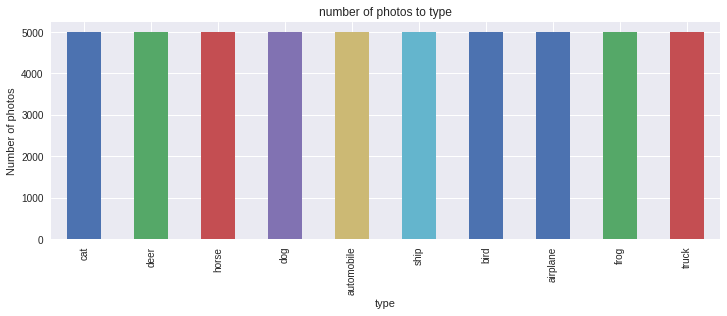

In [0]:
fig(figsize=(12,4))
pic_count= train_data['label'].value_counts()
plt.ylabel('Number of photos')
plt.xlabel('type')
pic_count.plot(kind = 'bar',title = 'number of photos to type')

so, as we can see we have the following types of photos:
* ship
* frog
* cat
* automobile
* bird
* truck
* airplane
* horse
* deer
* dog  
the types are balance , there are 5,000 samples for each type.

after we know how the train data divided between the 10 types, and which types we have, let's try to take a look at the images, and get deeper conclusions about them.  
we will load the data from keras.datasets, the train data is exactly the same as in kaggle. (the only difference between kaggle and keras is that in kaggle the test dataset is different)

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

let's take a look about the data structure:

In [0]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
print("%d megabytes" % ((x_train.size * x_train.itemsize)*0.000001)) # itemsize - Length of one array element in bytes

153 megabytes


as we know there are 50,000 samples, each one of them is 32 X 32 pixels with 3 channels. that weight 614MB.

now we will print 10 images for each type, each row will describe a type, and we will try to examine the difference between them and the challenges we might encounter while we form our classification model.

In [0]:
def plot_multiple_imgs(data,nrows=4,ncols=4,figsize=(18,18)):
    fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
    for i in range(nrows*ncols):
      if nrows>1:
        plot_ax = ax[i//ncols,i%ncols]
      else:
        plot_ax = ax[i]
      plot_ax.imshow(data[i])
      plot_ax.text(0.05, 0.1, str(i+1), color='white',backgroundcolor = 'black',transform=plot_ax.transAxes,weight='bold')

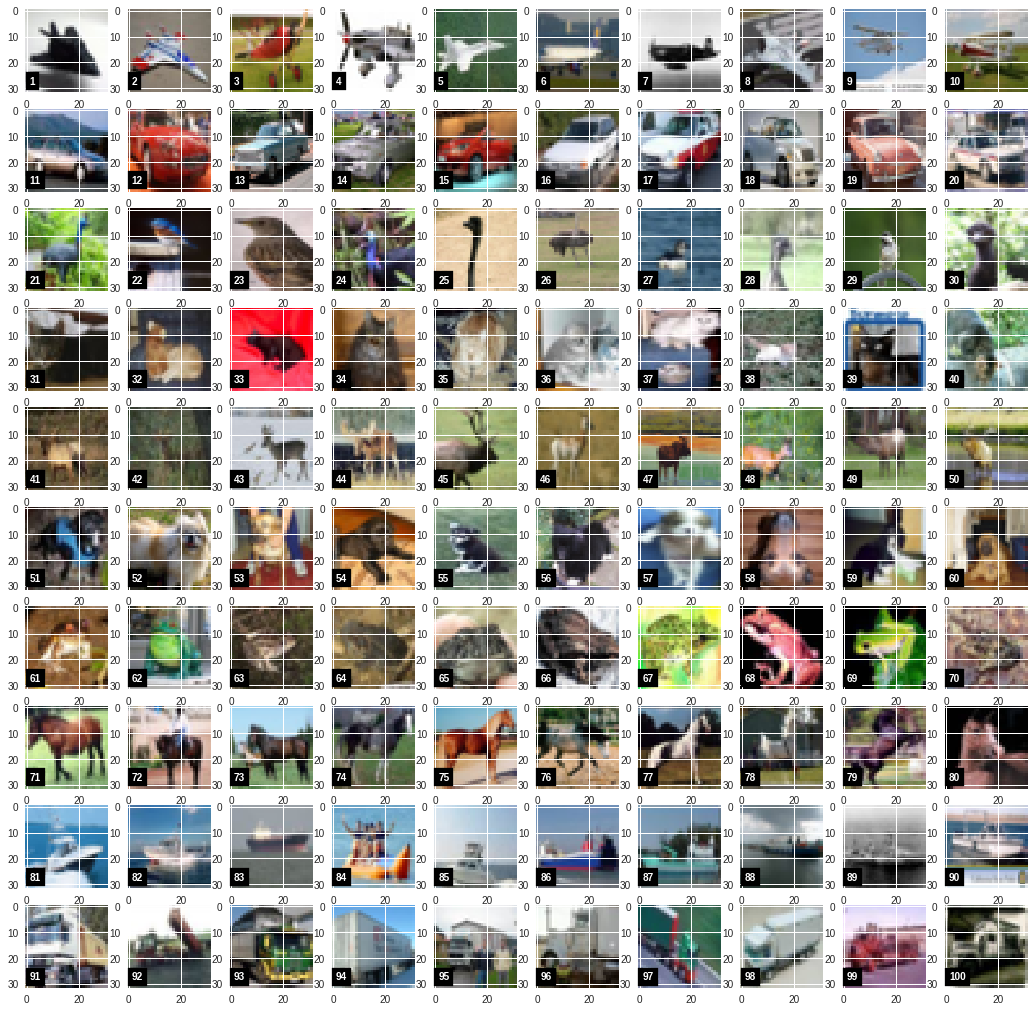

In [0]:
import numpy as np

indexes = np.where(y_train == [0])[0][:10]
for i in range(1,10):
  indexes = np.append(indexes,np.where(y_train == [i])[0][:10])
plot_multiple_imgs(x_train[indexes],10,10)

* we can notice that almost in all the images we printed, ***the object is in the middle of the image***, some of the images are very clear with one background color, such as 98, 71,80,68,29,18,1 and etc.  
while other are more complicated with background that contains lots of colors and shapes that may cause noise in the model,such as: 21,22,81,70. (we saw this situation with the 'right whale' kaggle competition, there we had to crop the whales from the original image in order to reduce the noise that the sea and waves added to the image)
* we can also notice that ***each object can be in different positions in different photos***, for example we can see in image 92 a truck with open baggage, and in 91 with close one. also in image 75 we can see a horse standing while in image 76 running.  
* ***different shape and colors to the same type***: image84 and image 83 are both calssify as ships while each ship looking totally different.  also image25 and image23 are both classified as bird, while it looks totally different (different species of birds).  
* **different light condition**- notice image42 vs image43, while the first is more dark and obscure, the second is bright and clear.
  
  
to conclude, each image for each type of object can be in any color, can be taken in different light condition, and its whole body can be in any position and varied shapes. in order to correctly classify instances so different, the network must learn to extract robust features that could be learned only after train a lot of different inputs. hence, we have to show to the network that we have to classify can be in an high variance and that the features extracted can be combined in a lot of different ways for the same type.  
in order to do that we will try to use ***data augmentation***.  

#### Data augmentation  
to decide which type of data augmentation we will use, we will visualize the augmentation we see as relevant in order to understand more deeply and feel more comfortable about our choosing and about the data that our cnn will train on.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

we write a function that get ImageDataGenerator object and print one batch of output.

In [0]:
def visualize_data_aug(datagen,row,col,figsize = (12,10)):  
  datagen.fit(x_train[indexes])
  # Configure batch size and retrieve one batch of images
  for X_batch, y_batch in datagen.flow(x_train[indexes], y_train[indexes], batch_size=row*col):
      # Show 9 images
      plot_multiple_imgs(X_batch,row,col,figsize)
      break

**flip** - the images in cifar-10 are natural, so there is no point to flip vertical. but fliping horizontal is relevant.

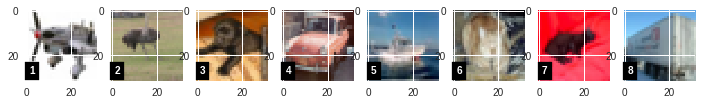

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True)
visualize_data_aug(datagen,1,8)

this will help our model to be more flexible to object position.
(we can see image4 and image19 from the original image plot, same image, while the car in different position)

**rotation** - will help for the same purpose.

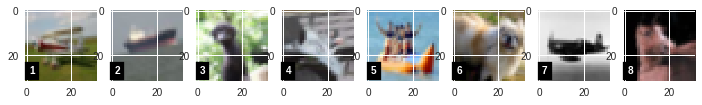

In [0]:
datagen = ImageDataGenerator(rotation_range=20)
visualize_data_aug(datagen,1,8)

image2 is rotate while image83 in the first plot is balanced. (more positions...)

**brightness**- with this augmentation we can varied the data, so the model will train also about darker and brighter images. (can mimic image that was taken in a drak room or with light expose) 

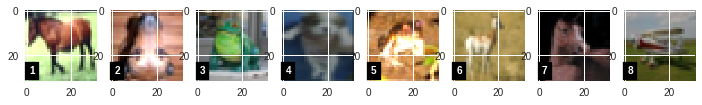

In [0]:
datagen = ImageDataGenerator(brightness_range=[0.6,1.5])
visualize_data_aug(datagen,1,8)

**shift**- because of the reason in most of the images the object in center we will use gentle shift, to create more positions in the image in our data for each type.

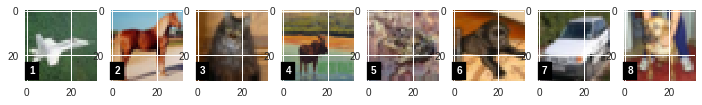

In [0]:
shift = 2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift,fill_mode='nearest')
visualize_data_aug(datagen,1,8)

and all together....

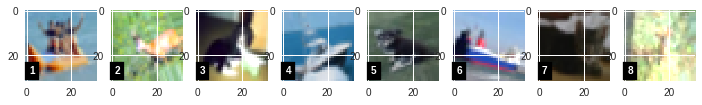

In [0]:
shift = 2
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift,fill_mode='nearest',
                             brightness_range=[0.6,1.5],
                             rotation_range=20,
                             horizontal_flip=True
                            )
visualize_data_aug(datagen,1,8)

we will try the above augmentation while we train our model, we still not sure that all of them will help us, but it's worth a try. and we will maybe try some more when we examine our model result to understand which kind of types were not classified correctly.

### preprocessing-

**normalization** - we will use *min_max normalization* in order to normalize the RGB pixels of an image from range 0 to 255 (int) to [0,1] (float). this will help the gradient to convergent faster and to avoid from Vanishing gradient problem (as we studied in class).  

first we will convert the data from int to float:

In [0]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

define our min_max normalize function

In [0]:
def normalize_data(data):
  for i in range(data.shape[0]):
    min = np.min(data[i])
    max = np.max(data[i])
    data[i] = (data[i]-min) / (max-min)
  return data

normalize the data

In [16]:
x_train = normalize_data(x_train)
x_train[0] # to check if it is normalized

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [17]:
x_test = normalize_data(x_test)
x_test[0] # to check if it is normalized

array([[[0.59917355, 0.4090909 , 0.14876033],
        [0.60330576, 0.40495867, 0.14049587],
        [0.6280992 , 0.42561984, 0.1570248 ],
        ...,
        [0.5123967 , 0.338843  , 0.09504132],
        [0.46694216, 0.32231405, 0.09504132],
        [0.42561984, 0.29752067, 0.08264463]],

       [[0.57438016, 0.4090909 , 0.1570248 ],
        [0.57024795, 0.40082645, 0.11157025],
        [0.60330576, 0.41735536, 0.1322314 ],
        ...,
        [0.5082645 , 0.338843  , 0.07438017],
        [0.46280992, 0.32231405, 0.0785124 ],
        [0.43801653, 0.30991736, 0.08677686]],

       [[0.57024795, 0.40082645, 0.14049587],
        [0.57024795, 0.3966942 , 0.08264463],
        [0.59917355, 0.40495867, 0.09504132],
        ...,
        [0.5206612 , 0.35123968, 0.08677686],
        [0.48347107, 0.338843  , 0.08677686],
        [0.44214877, 0.3140496 , 0.08264463]],

       ...,

       [[0.22727273, 0.45867768, 0.677686  ],
        [0.11983471, 0.35950413, 0.55785125],
        [0.07438017, 0

**convert y to categorial**

let's take a look of y_train:

In [18]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

as we can notice each sample is classified by array with one elemnt that indicate the classification.  our model will predict a set of probabilities of each class of image, hence we have to express those probabilities in code, by a vector having the same number of elements as the number of classes of the image, a vector like this called *dummie or categorial*.
  
let's define a function that will convert y_train to categorial:


In [0]:
def to_categorial(x,num_classes=10):
    encoded = np.zeros((len(x), num_classes))  
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    return encoded

In [20]:
y_categorial = to_categorial(y_train)
y_categorial

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [21]:
y_test_categorial = to_categorial(y_test)
y_test_categorial

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

let's save the data:  

In [0]:
np.save('./gdrive/My Drive/Work-1/CIFAR/data/data_X.npy', x_train)
np.save('./gdrive/My Drive/Work-1/CIFAR/data/data_Y_categorial.npy', y_categorial)
np.save('./gdrive/My Drive/Work-1/CIFAR/data/test_X.npy', x_test)
np.save('./gdrive/My Drive/Work-1/CIFAR/data/test_y.npy', y_test_categorial)

### Benchmarks

there are many benchmarks for many different classification models for this task.  
in the following link we can impressed:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html  
best result: 96.53  
on the leaderboard of kaggle in order to be in the first quarter we have to gain 0.75 accuracy.